In [1]:
from astropy.table import Table
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt

In [2]:
# defining the Dataset class
class train_set(Dataset):
    def __init__(self,file):
        fn = h5py.File(file, 'r')
        self.f = fn
        
    def __len__(self):
        return self.f['group_1']['data'].shape[1]
  
    def __getitem__(self, index):
        # get data
        dset = self.f['group_1']['data']
        x = dset[:].T
        x = torch.Tensor(x[index])
        

        # get label
        ydset = self.f['group_1']['label']
        y = ydset[:].T
        y = torch.Tensor(y[index])
        # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
        # get error in label # comment out for non-error label runs
        errdset = self.f['group_1']['e_label']
        err = errdset[:].T
        err = torch.Tensor(err[index])
        return (x,y,err)

class test_set(Dataset):
    def __init__(self,file):
        fn = h5py.File(file, 'r')
        self.f = fn
        
    def __len__(self):
        return self.f['group_2']['data'].shape[1]
  
    def __getitem__(self, index):
        # get data
        dset = self.f['group_2']['data']
        x = dset[:].T
        x = torch.from_numpy(x[index])

        # get label
        ydset = self.f['group_2']['label']
        y = ydset[:].T
        y = torch.from_numpy(y[index])
        
        # get error in label # comment out for non-error label runs
        errdset = self.f['group_2']['e_label']
        err = errdset[:].T
        err = torch.from_numpy(err[index])
        return (x.float(),y.float(),err.float())

In [3]:
# training_data = train_set("/arc/home/aydanmckay/mydata.h5")
# test_data = test_set("/arc/home/aydanmckay/mydata.h5")
training_data = train_set("/arc/home/aydanmckay/mydataelabelssmallscalecuts.h5")
test_data = test_set("/arc/home/aydanmckay/mydataelabelssmallscalecuts.h5")
##################################################################################
# training_data = test_set("/arc/home/aydanmckay/mydataelabelssmallscalecuts.h5")
# test_data = test_set("/arc/home/aydanmckay/mydataelabelssmallscalecuts.h5")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 110)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
train_dataloader = DataLoader(
    training_data,
    batch_size=32,
    # shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    # shuffle=True
)

In [6]:
model = Net()
print(model)

Net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=110, bias=True)
  )
)


In [7]:
lr = 1e-3
# batch_size = 64
epochs = 5

In [8]:
loss_fn = nn.L1Loss()
# loss_fn = nn.MSELoss()

In [9]:
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=lr,
#     momentum=0.9
# )
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [10]:
def train(dataloader, model, loss_fn, optimizer,epoch):
    size = len(dataloader.dataset)
    losslist = []
    batchlist = []
    for batch, (X, y, z) in enumerate(dataloader):
        batchlist.append(batch)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred/z**2, y/z**2)
        losslist.append(loss.detach().numpy())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    plt.plot(batchlist,losslist)
    plt.xlabel('Batch Number')
    plt.ylabel('Loss (Weighted L1)')
    plt.title('Training Loss Over Epoch '+str(epoch+1))
    plt.savefig('/arc/home/aydanmckay/torchplots/trainlossWL1smallepoch'+str(epoch)+'scalecutsep5.png')
    plt.show()

def test(dataloader, model, loss_fn,epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    preds = []
    with torch.no_grad():
        for X, y, z in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred/z**2, y/z**2).item()
            correct += (pred == y).type(torch.float).sum().item()
            preds.append(pred)
    
    preds = np.array(preds)
    res(preds,dataloader,epoch,resi='res')
    res(preds,dataloader,epoch,resi='rel')
    res(preds,dataloader,epoch,resi='err')
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

def res(preds,dataloader,epoch,resi='rel'):
    fig, axs = plt.subplots(110)
    fig.set_figheight(600)
    
    with torch.no_grad():
        for num, (X, y, z) in enumerate(dataloader):
            if resi == 'rel':
                residual = (y-preds[num])/y
                string = 'Relative Residual'
            elif resi == 'err':
                residual = (y-preds[num])/z
                string = 'Residual Over Label Error'
            elif resi == 'res':
                residual = y-preds[num]
                string = 'Residual'
            for it in range(len(y.T)):
                axs[it].plot(y.T[it],residual.T[it],'k.',alpha=0.1)
                axs[it].set_xlabel('Observed XP Coefficient Value')
                axs[it].set_ylabel('Relative Residual')
                axs[it].set_title('XP Coefficient '+str(it+1)+' '+string)
                
    plt.savefig('/arc/home/aydanmckay/torchplots/test'+resi+'residualsWL1smallepoch'+str(epoch)+'scalecutsep5.png')
    plt.close()

Epoch 1
-------------------------------
loss: 1.332545  [    0/45000]
loss: 0.202131  [ 3200/45000]
loss: 0.115722  [ 6400/45000]
loss: 0.132012  [ 9600/45000]
loss: 0.156399  [12800/45000]
loss: 0.122599  [16000/45000]
loss: 0.143460  [19200/45000]
loss: 0.105557  [22400/45000]
loss: 0.102911  [25600/45000]
loss: 0.088856  [28800/45000]
loss: 0.097205  [32000/45000]
loss: 0.087065  [35200/45000]
loss: 0.117887  [38400/45000]
loss: 0.115246  [41600/45000]
loss: 0.118515  [44800/45000]


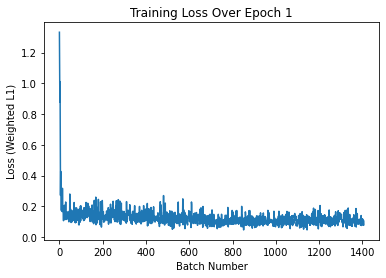

/tmp/ipykernel_9835/390972310.py:39: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  preds = np.array(preds)
/tmp/ipykernel_9835/390972310.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds = np.array(preds)


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.100149 

Epoch 2
-------------------------------
loss: 0.083829  [    0/45000]
loss: 0.148750  [ 3200/45000]
loss: 0.084286  [ 6400/45000]
loss: 0.101765  [ 9600/45000]
loss: 0.137021  [12800/45000]
loss: 0.089410  [16000/45000]
loss: 0.119323  [19200/45000]
loss: 0.125847  [22400/45000]
loss: 0.084928  [25600/45000]
loss: 0.083522  [28800/45000]
loss: 0.089994  [32000/45000]
loss: 0.076718  [35200/45000]
loss: 0.091955  [38400/45000]
loss: 0.110357  [41600/45000]
loss: 0.116098  [44800/45000]


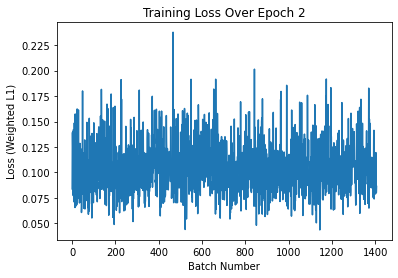

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.101531 

Epoch 3
-------------------------------
loss: 0.084809  [    0/45000]
loss: 0.161233  [ 3200/45000]
loss: 0.085186  [ 6400/45000]
loss: 0.102297  [ 9600/45000]
loss: 0.135200  [12800/45000]
loss: 0.087048  [16000/45000]
loss: 0.119481  [19200/45000]
loss: 0.124764  [22400/45000]
loss: 0.079020  [25600/45000]
loss: 0.083884  [28800/45000]
loss: 0.082854  [32000/45000]
loss: 0.072904  [35200/45000]
loss: 0.088773  [38400/45000]
loss: 0.110904  [41600/45000]
loss: 0.116057  [44800/45000]


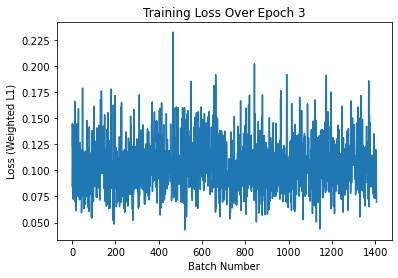

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.099635 

Epoch 4
-------------------------------
loss: 0.083983  [    0/45000]
loss: 0.159513  [ 3200/45000]
loss: 0.084331  [ 6400/45000]
loss: 0.100726  [ 9600/45000]
loss: 0.135103  [12800/45000]
loss: 0.088592  [16000/45000]
loss: 0.125662  [19200/45000]
loss: 0.143885  [22400/45000]
loss: 0.078420  [25600/45000]
loss: 0.089296  [28800/45000]
loss: 0.081275  [32000/45000]
loss: 0.077752  [35200/45000]
loss: 0.089856  [38400/45000]
loss: 0.107858  [41600/45000]
loss: 0.116249  [44800/45000]


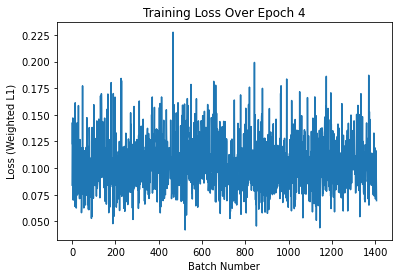

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.099323 

Epoch 5
-------------------------------
loss: 0.083792  [    0/45000]
loss: 0.144660  [ 3200/45000]
loss: 0.092032  [ 6400/45000]
loss: 0.099360  [ 9600/45000]
loss: 0.134883  [12800/45000]
loss: 0.083750  [16000/45000]
loss: 0.135294  [19200/45000]
loss: 0.145157  [22400/45000]
loss: 0.077601  [25600/45000]
loss: 0.090634  [28800/45000]
loss: 0.081502  [32000/45000]
loss: 0.084495  [35200/45000]
loss: 0.088885  [38400/45000]
loss: 0.111988  [41600/45000]
loss: 0.116959  [44800/45000]


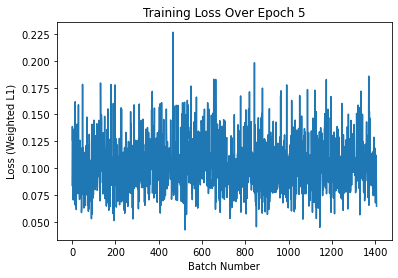

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.098938 

Training completed


In [11]:
testloss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer,t)
    tloss = test(test_dataloader, model, loss_fn,t)
    testloss.append(tloss)
print("Training completed")

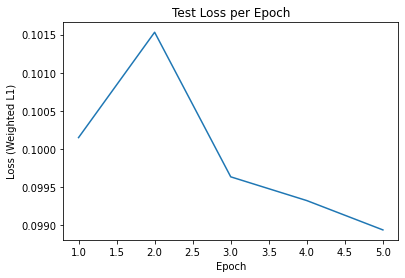

In [12]:
plt.plot(range(1,epochs+1),testloss)
plt.xlabel('Epoch')
plt.ylabel('Loss (Weighted L1)')
plt.title('Test Loss per Epoch')
plt.savefig('/arc/home/aydanmckay/torchplots/testlossWL1smallscalecutsep5.png')
plt.show()

In [13]:
torch.save(model.state_dict(), "/arc/home/aydanmckay/torchmodel/torchmodelWL1smallscalecutsep5.pth")